#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [3]:
%pip install lightgbm -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

### Константы

In [19]:
RANDOM_STATE = 42

## Подготовка

In [5]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')
except:
    print("Загрузка файлов не удалась!")

In [6]:
display(data.head(10))
print('-------------------------------------')
data.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Пропусков в данных не обнаружено. Тип данных в столбце `datetime` имеет некорректный тип данных *object* вместо *datetime*.

Проверка на дубликаты:

In [7]:
data.duplicated().sum()

0

Дубликатов в таблице не найдено.

Приведем данные в столбце `datetime` к типу *datetime64*:

In [8]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

Установим столбец `datetime` как индекс:

In [9]:
data = data.set_index('datetime')

Проверим столбец дат на монотонность:

In [10]:
data.sort_index(inplace=True)
data.index.is_monotonic

True

Значение времени растет монотонно.

Проверка временного ряда на наличие пропусков:

In [11]:
data_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H') # ожидаемый диапазон по часам
df_missing = data_range.difference(data.index) # датасет пропущенных значений

if df_missing.empty:
    print('Пропущенных значений нет')
else:
    print(f'Пропущенные значения есть: \n{df_missing}')

Пропущенных значений нет


## Анализ

По условию ТЗ необходимо выполнить ресемплирование по одному часу:

In [12]:
data = data.resample('1H').sum()

### Скользящее среднее и стандартное отклонение

Рассмотрим как измненялось кол-ва заказов по часам на графике. Также дополнительно построим график скользящего среднего, которое позволяет сгладить колебания функции и стандартное отклонение, которое позволяет определить стационароность временного ряда. Размер окна выберем равным 24 часам. 

In [13]:
df_analysed = data.copy() # датасет для изучения
df_analysed['rolling_mean_day'] = df_analysed['num_orders'].rolling(24).mean()
df_analysed['rolling_std_day'] = df_analysed['num_orders'].rolling(24).std()

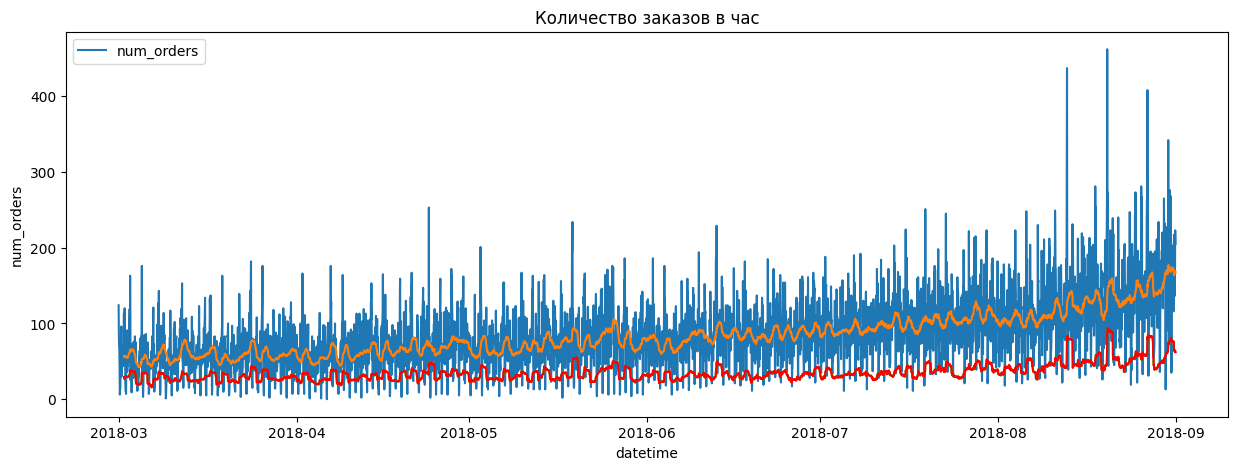

In [14]:
plt.figure(figsize=(15,5))
plt.plot(df_analysed)
plt.plot(df_analysed.iloc[:, 2], color='red')
plt.title('Количество заказов в час')
plt.legend(list(data.columns))
plt.xlabel('datetime')
plt.ylabel('num_orders')
plt.show()

На графике можно видеть плавное увеличение 24-часового скользящего среднего (оранжевая линия). Стандартное отклонение (красная линия) стабильно на изучаемом промежутке, но к концу начинает колебаться. Пока что можно сказать, что временной ряд ближе к концу изучаемого периода не выглядит стационарным. 

### Тренды и сезонность

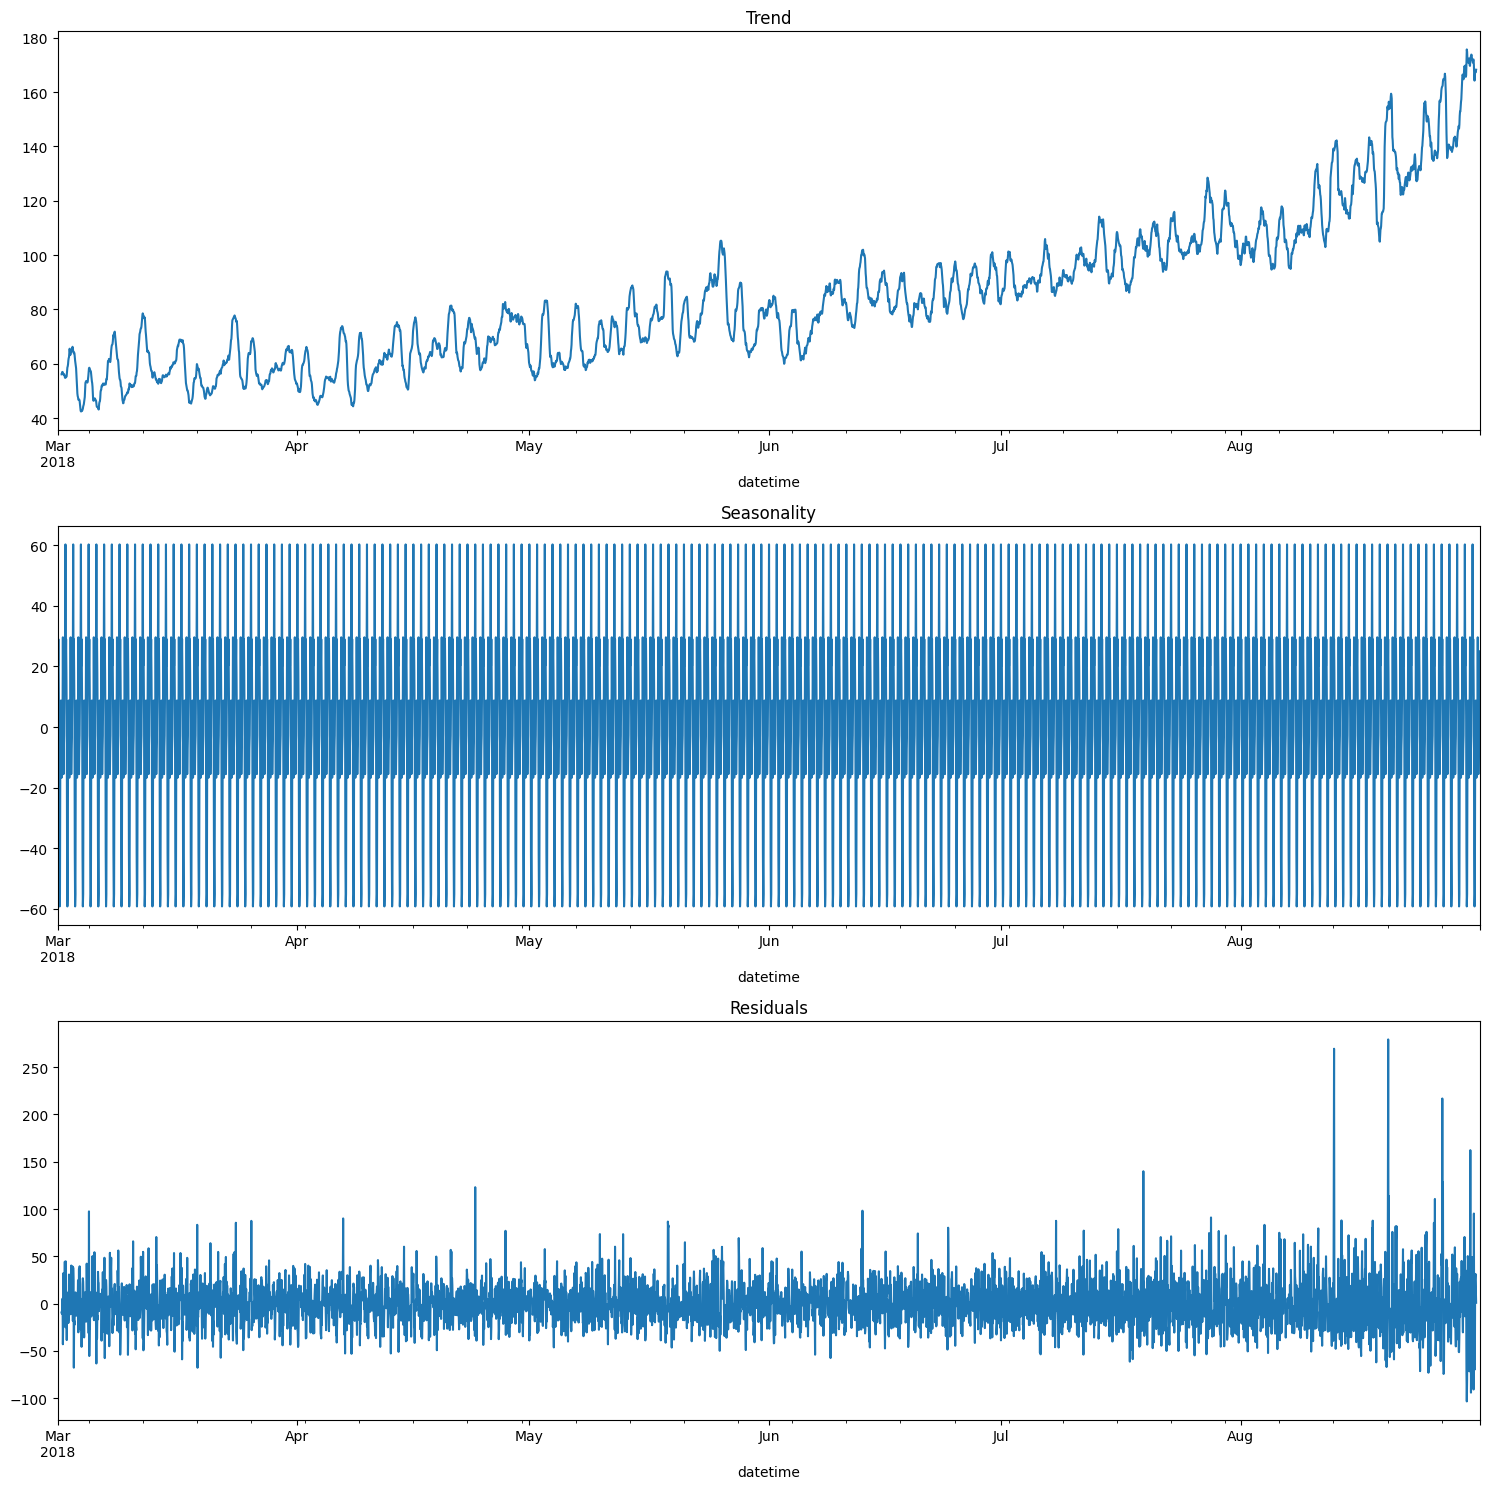

In [15]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На графике тренда заметен рост, что соотносится с ранними наблюдениями. Шумы (или остатки) усиливаются к концу, их природа неясна. График сезонности рассмотрим поподробнее: 

<AxesSubplot:xlabel='datetime'>

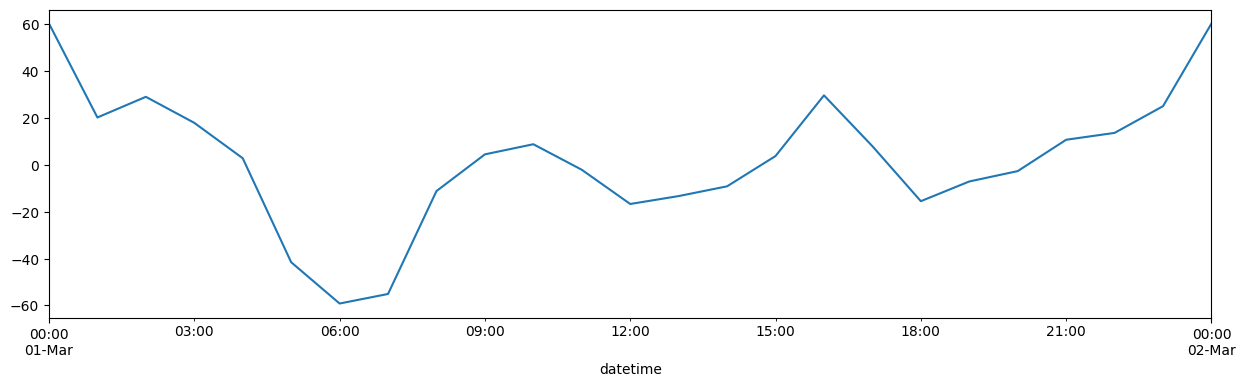

In [16]:
# Сезонность в 1 сутки
plt.figure(figsize=(15, 4))
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 00:00:00'].plot()

Как видим по графику суточного спроса пик заказов приходится в полночь, а наименьший на утренее время (6:00). 

<AxesSubplot:xlabel='datetime'>

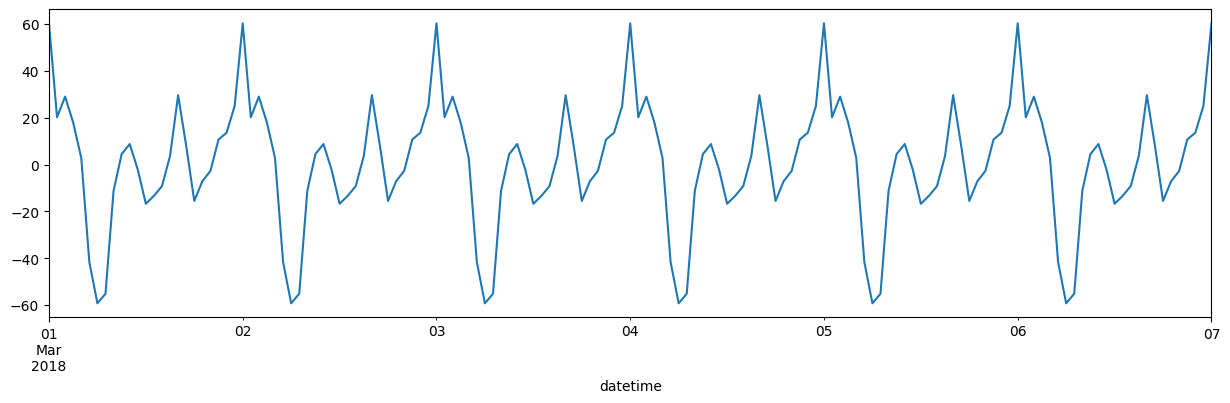

In [17]:
# Сезонность в неделю
plt.figure(figsize=(15, 4))
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-07 00:00:00'].plot()

На графике выше также заметно, что пик заказов приходится на конец суток.

**Вывод:** В ходе анализа временного ряда было обнаружено, что в количестве заказов такси имеется тренд на возрастание ближе к концу рассматриваемого периода. При исследовании графиков сезонности и трендов выяснилось, что пик заказов приходится в ночные часы, минимальный в 6:00.

## Обучение

### Добавление признаков и разбивка на выборки

Для прогнозирование временного ряда добавим новые признаки, а именно:
* Календарные признаки (`hour`, `dayofweek`)
* Отстающие признаки (`lag_i`) - *максимальное запаздывание определим в 24 часа*
* Скользящее среднее (`rolling_mean`) - *размер окна также выберем равным 24*

In [18]:
# Функция добавления новых признаков
def make_features(data, max_lag, rolling_mean_window):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag+1):
        data[f'lag{lag}'] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_window).mean()  

In [20]:
make_features(data, 24, 24)
data.dropna(inplace=True)

In [21]:
data.head(5)

,num_orders,hour,dayofweek,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,1,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,3,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


Разобъем данные на тренировочную и тестовую выборки (10%) без перемешивания:

In [24]:
# Разбиение датасета на входные признаки и таргет
X = data.drop('num_orders', axis=1)
y = data['num_orders']

# Разделение на 3 выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.1,
    shuffle=False,
    random_state=RANDOM_STATE
)

Проверим последовательность разбиения:

In [25]:
X_train.index.min(), X_train.index.max()

(Timestamp('2018-03-02 00:00:00', freq='H'),
 Timestamp('2018-08-13 15:00:00', freq='H'))

In [26]:
X_test.index.min(), X_test.index.max()

(Timestamp('2018-08-13 16:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

Выборки временного ряда разбиты верно.

Сравнение моделей будем проводить "по возрастанию": 
* *DummyRegressor* (Константная модель)
* *LinearRegressor* (Линейная регрессия)
* *DecisionTreeRegressor* (Дерево регрессии)
* *LGBMRegressor* (Модель регрессии градиентного бустинга)

Полученные результаты будем сводить в отдельную таблицу:

In [27]:
results_df = pd.DataFrame({'Модель': [], 'RMSE_train': [], 'RMSE_test': []})

### Dummy модель (константная модель)

In [28]:
# Медианное значение
model_DR = DummyRegressor(strategy='median')
model_DR.fit(X_train, y_train)

predicts_DR_train = model_DR.predict(X_train)
predicts_DR_test = model_DR.predict(X_test)

RMSE_DR_train = mean_squared_error(y_train, predicts_DR_train, squared=False)
RMSE_DR_test = mean_squared_error(y_test, predicts_DR_test, squared=False)
print(f'Значение RMSE для медианного значения (тренировочная выборка): {RMSE_DR_train}')
print(f'Значение RMSE для медианного значения (тестовая выборка): {RMSE_DR_test}')
print()

# Среднее значение
model_DR_mean = DummyRegressor()
model_DR_mean.fit(X_train, y_train)

predicts_DR_mean_train = model_DR_mean.predict(X_train)
predicts_DR_mean_test = model_DR_mean.predict(X_test)

RMSE_DR_mean_train = mean_squared_error(y_train, predicts_DR_mean_train, squared=False)
RMSE_DR_mean_test = mean_squared_error(y_test, predicts_DR_mean_test, squared=False)
print(f'Значение RMSE для среднего значения (тренировочная выборка): {RMSE_DR_mean_train}')
print(f'Значение RMSE для среднего значения (тестовая выборка): {RMSE_DR_mean_test}')

Значение RMSE для медианного значения (тренировочная выборка): 38.85899194601848
Значение RMSE для медианного значения (тестовая выборка): 87.21093811714634

Значение RMSE для среднего значения (тренировочная выборка): 38.70541274453604
Значение RMSE для среднего значения (тестовая выборка): 84.68768287118466


In [29]:
results_df.loc[0] = ['DummyRegressor', RMSE_DR_mean_train, RMSE_DR_mean_test]

### LinearRegression (Линейная регрессия)

In [30]:
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

predicts_LR_train = model_LR.predict(X_train)
predicts_LR_test = model_LR.predict(X_test)

RMSE_LR_train = mean_squared_error(y_train, predicts_LR_train, squared=False)
RMSE_LR_test = mean_squared_error(y_test, predicts_LR_test, squared=False)

print(f'Значение RMSE для линейной регрессии (тренировочная выборка): {RMSE_LR_train}')
print(f'Значение RMSE для линейной регрессии (тестовая выборка): {RMSE_LR_test}')

Значение RMSE для линейной регрессии (тренировочная выборка): 25.84476620987006
Значение RMSE для линейной регрессии (тестовая выборка): 45.224094905317585


In [31]:
results_df.loc[1] = ['LinearRegression', RMSE_LR_train, RMSE_LR_test]

### DecisionTreeRegressor (Дерево решений)

Для подбора гиперпараметров при работе с временными рядами необходимо использовать надлежащий кросс-валидатор - *TimeSeriesSplit*.  

In [32]:
# Определим словарь перебираемых гиперпараметров
tree_parameters = {
    'max_depth': range(2, 10),
    'min_samples_leaf': range(2, 10),
    'min_samples_split': range(2, 6)
}

tscv = TimeSeriesSplit(n_splits=7)

# Инициализация модели
model_TR = DecisionTreeRegressor(random_state = RANDOM_STATE)

# Случайный поиск с RMSE -> 0
rs_TR = RandomizedSearchCV(
    model_TR,
    tree_parameters,
    n_jobs=-1,
    cv=tscv,
    scoring = 'neg_root_mean_squared_error',
    random_state = RANDOM_STATE
)

# Поиск гиперпараметров
rs_TR.fit(X_train, y_train)

print('Лучшие гиперпараметры для DecisionTreeRegressor', rs_TR.best_params_)

Лучшие гиперпараметры для DecisionTreeRegressor {'min_samples_split': 3, 'min_samples_leaf': 7, 'max_depth': 5}


In [33]:
model_TR_best = DecisionTreeRegressor(min_samples_split=3, min_samples_leaf=7, max_depth=5, random_state = RANDOM_STATE) 
model_TR_best.fit(X_train, y_train)

predicts_TR_train = model_TR_best.predict(X_train)
predicts_TR_test = model_TR_best.predict(X_test)

RMSE_TR_train = mean_squared_error(y_train, predicts_TR_train, squared=False)
RMSE_TR_test = mean_squared_error(y_test, predicts_TR_test, squared=False)

print(f'Значение RMSE для Дерева решений (тренировочная выборка): {RMSE_TR_train}')
print(f'Значение RMSE для Дерева решений (тестовая выборка): {RMSE_TR_test}')

Значение RMSE для Дерева решений (тренировочная выборка): 25.011223966754226
Значение RMSE для Дерева решений (тестовая выборка): 53.819297903566316


In [34]:
results_df.loc[2] = ['DecisionTreeRegressor', RMSE_TR_train, RMSE_TR_test]

###  LGBMRegressor (Градиентный бустинг)

In [35]:
# Аналогично с DecisionTreeRegressor
lgbmr_parameters = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': range(90, 120, 10),
    'num_leaves': range(50, 130, 20)
}

tscv = TimeSeriesSplit(n_splits=7)
   
model_LGBMR = LGBMRegressor(random_state=RANDOM_STATE)

rs_LGBMR = RandomizedSearchCV(
    model_LGBMR, 
    lgbmr_parameters, 
    n_jobs=-1, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE
)

rs_LGBMR.fit(X_train, y_train)
print('Лучшие гиперпараметры для LGBMRegressor', rs_LGBMR.best_params_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4838
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 27
[LightGBM] [Info] Start training from score 78.451417
Лучшие гиперпараметры для LGBMRegressor {'num_leaves': 110, 'n_estimators': 110, 'learning_rate': 0.05}


In [36]:
model_LGBMR_best = LGBMRegressor(num_leaves=110, n_estimators=110, learning_rate=0.05, random_state = RANDOM_STATE) 
model_LGBMR_best.fit(X_train, y_train)

predicts_LGBMR_train = model_LGBMR_best.predict(X_train)
predicts_LGBMR_test = model_LGBMR_best.predict(X_test)

RMSE_LGBMR_train = mean_squared_error(y_train, predicts_LGBMR_train, squared=False)
RMSE_LGBMR_test = mean_squared_error(y_test, predicts_LGBMR_test, squared=False)

print(f'Значение RMSE для градиентного бустинга (тренировочная выборка): {RMSE_LGBMR_train}')
print(f'Значение RMSE для градиентного бустинга (тестовая выборка): {RMSE_LGBMR_test}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4838
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 27
[LightGBM] [Info] Start training from score 78.451417
Значение RMSE для градиентного бустинга (тренировочная выборка): 8.778105711812366
Значение RMSE для градиентного бустинга (тестовая выборка): 42.488987553827066


In [37]:
results_df.loc[3] = ['LGBMRegressor', RMSE_LGBMR_train, RMSE_LGBMR_test]

## Тестирование

Посмотрим какие результаты выдали 4 модели:

In [38]:
results_df.sort_values(by='RMSE_test')

,Модель,RMSE_train,RMSE_test
3,LGBMRegressor,8.778106,42.488988
1,LinearRegression,25.844766,45.224095
2,DecisionTreeRegressor,25.011224,53.819298
0,DummyRegressor,38.705413,84.687683


Наилучший результат на тестовой выборке (хоть и с незначительным отрывом) показала модель LGBMRegressor. 

In [39]:
# Временной ряд прогноза
predicts = pd.DataFrame(predicts_LGBMR_test, index = y_test.index)

In [40]:
df_compare = pd.concat([y_test, predicts], axis=1)
df_compare.columns = ['Реальный данные', 'Прогноз модели']

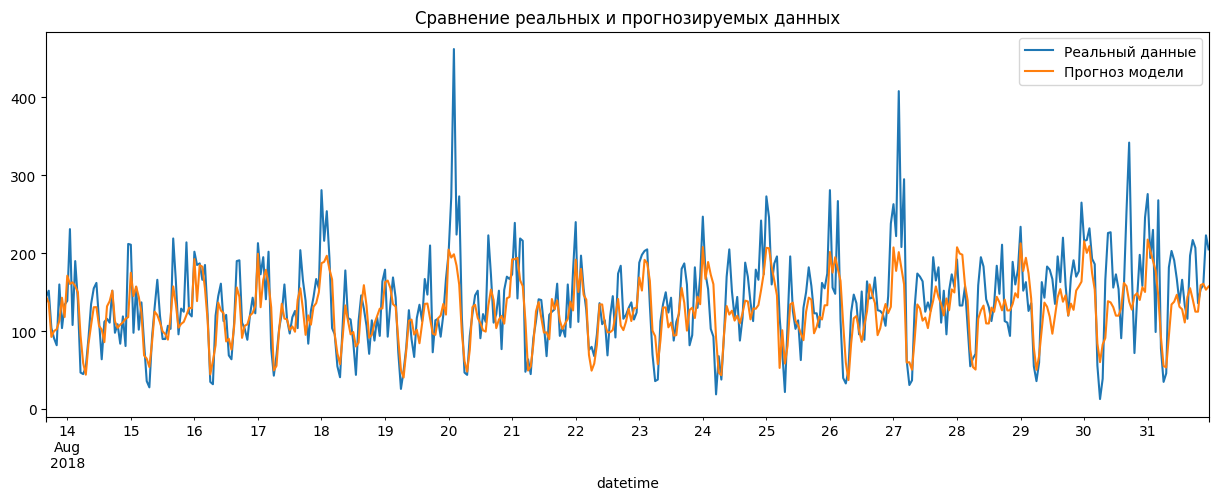

In [41]:
df_compare.plot(figsize=(15, 5))
plt.title("Сравнение реальных и прогнозируемых данных")
plt.show()

Итоговая модель показала хороший результат - на графике виден приемлимый прогноз.

## Вывод

Для компании «Чётенькое такси» были разработаны и исследованы модели по предсказанию количества заказов такси в аэропортах. 

В ходе исследования исходного датафрейма или временного ряда было обнаружено, что наибольшое число заказов приходится на ночные часы и снижается до минимума к 6:00 утра. Также стоит добавить, что к концу исследуемого периодп заметен тренд на плавное увеличение всего временного ряда.

Для предсказания заказов такси было разработано и проанализировано 3 модели: линейной регрессии, регресионного дерева решений и градиентного бустинга. Путем сравнения их результатов на тестовой выборке была определена наилушая модель (с небольшим отрывом) - градиентный бустинг значение RMSE которой оказалось меньше требуемых 48. 